# Business inteliggence and Time series analysis
In this analysis I'll process a dataframe coming from a pizzeria to extract meaningful information useful for implenting and adapting the marketing strategies. Then I'll decompose the revenue time series to analyze its seasonality and trend, thus providing a revenue forecast for the next year.

The questions that I'll try to answer are the following:

•What days and times do we tend to be busiest?

•How many pizzas are we making during peak periods?

•What are our best and worst-selling pizzas?

•What's our average order value?

•How well are we utilizing our seating capacity? (the pizzeria has 15 tables and 60 seats)

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import kpss,adfuller
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import xgboost as xgb


In [5]:
path=r"C:\Users\Utente\Desktop\Various Datasets\Data Model - Pizza Sales.xlsx"
df=pd.read_excel(path)
pd.set_option('display.max_columns', None)
df

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [6]:
df['daytime']=df['order_date'].astype(str)+' '+df['order_time'].astype(str)
df['daytime']=pd.to_datetime(df['daytime'])
df.set_index(df['daytime'])

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,daytime
daytime,,,,,,,,,,,,,
2015-01-01 11:38:36,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015-01-01 11:38:36
2015-01-01 11:57:40,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 11:57:40
2015-01-01 11:57:40,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015-01-01 11:57:40
2015-01-01 11:57:40,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015-01-01 11:57:40
2015-01-01 11:57:40,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-01-01 11:57:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 21:23:10,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,2015-12-31 21:23:10
2015-12-31 21:23:10,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,2015-12-31 21:23:10
2015-12-31 21:23:10,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,2015-12-31 21:23:10


In [7]:
#What's our average order value?
mean_total_price = df['total_price'].mean()
print('{:.2f}$'.format(mean_total_price))


16.82$


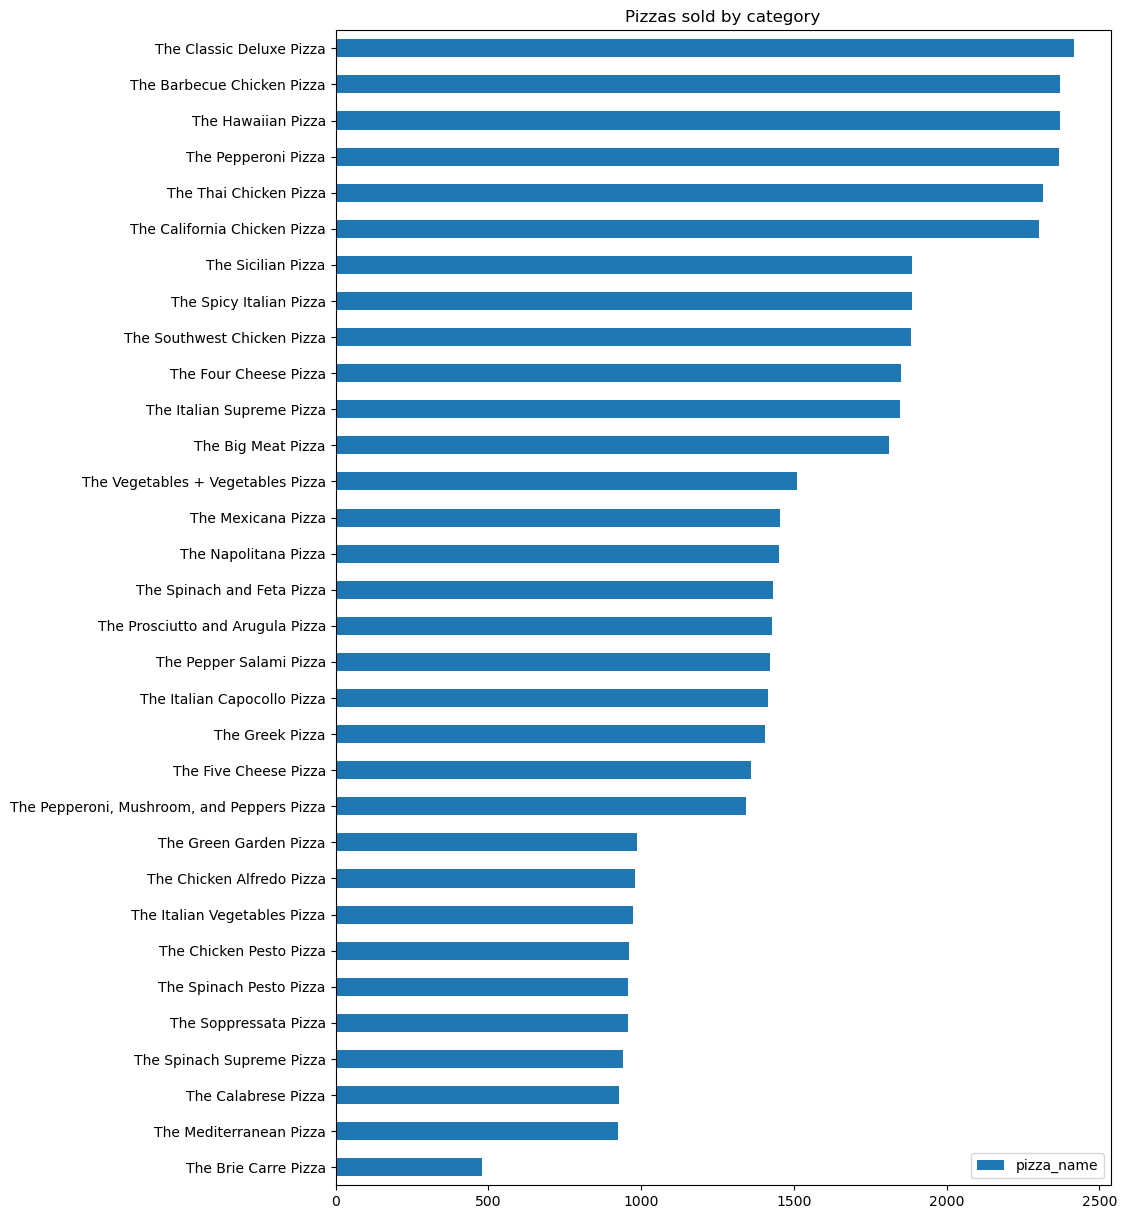

In [57]:
pic1=pd.DataFrame(df['pizza_name'].value_counts().sort_values())
pic1.plot.barh(figsize=(10,15))
plt.title('Pizzas sold by category')
plt.show()

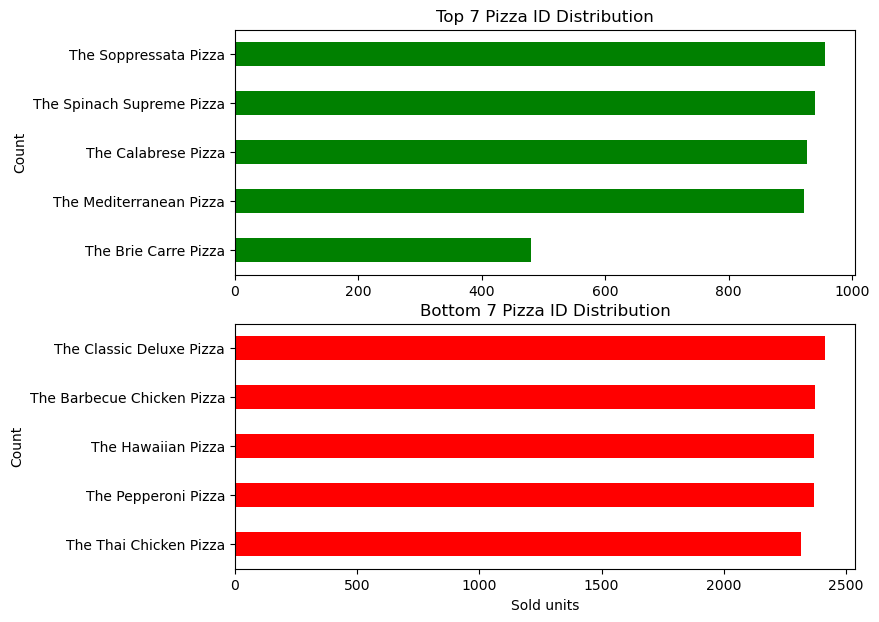

In [9]:
top_7 = pic1.head(5)
bottom_7 = pic1.tail(5)

# Creating subplots
fig, axes = plt.subplots(2,1, figsize=(8, 7))

# Plotting the first 7 pizzas on the first subplot
top_7.plot.barh(ax=axes[0],color='green')
axes[0].set_title('Top 7 Pizza ID Distribution')
axes[0].set_ylabel('Count')
axes[0].legend().set_visible(False)

# Plotting the last 7 pizzas on the second subplot
bottom_7.plot.barh(ax=axes[1],color='red')
axes[1].set_title('Bottom 7 Pizza ID Distribution')
axes[1].set_xlabel('Sold units')
axes[1].set_ylabel('Count')
axes[1].legend().set_visible(False)

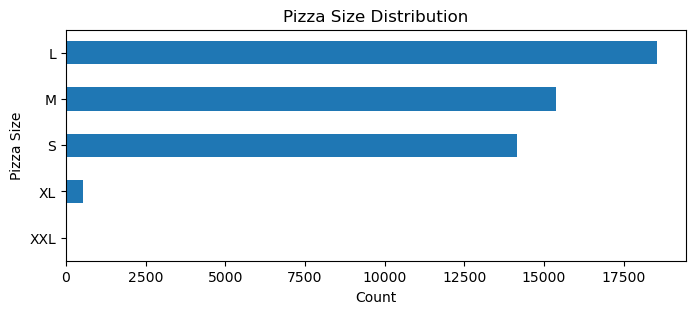

In [10]:
pic2 = pd.DataFrame(df['pizza_size'].value_counts().sort_values())
ax = pic2.plot(kind='barh', figsize=(8, 3), legend=False) 
ax.set_xlabel('Count')
ax.set_ylabel('Pizza Size')
ax.set_title('Pizza Size Distribution')

plt.show()

In [11]:
pivot_table1 = df.pivot_table( index='pizza_name',columns=df['daytime'].dt.month, values='total_price', aggfunc='sum')
cols=pivot_table1.columns
pivot_table1['total_revenue']=pivot_table1[cols].sum(axis=1)
pivot_table1 =pivot_table1.sort_values('total_revenue',ascending=False)
pivot_table1

daytime,1,2,3,4,5,6,7,8,9,10,11,12,total_revenue
pizza_name,,,,,,,,,,,,,
The Thai Chicken Pizza,3657.25,3009.25,3843.75,3686.00,3558.25,3505.00,4073.75,3272.50,3736.25,3503.25,3776.00,3813.00,43434.25
The Barbecue Chicken Pizza,3770.25,3416.75,4049.25,3788.50,3953.50,3377.50,3784.25,3300.25,3380.00,2946.00,3881.75,3120.00,42768.00
The California Chicken Pizza,3471.50,3537.00,3457.50,3092.00,3561.25,3870.50,3252.25,3977.25,3088.75,2833.50,3692.75,3575.25,41409.50
The Classic Deluxe Pizza,2941.50,2705.00,3168.00,3342.50,3444.00,3029.00,3554.50,3187.00,3257.50,3075.50,3379.50,3096.50,38180.50
The Spicy Italian Pizza,2762.00,2646.25,3205.75,2758.25,3430.75,2985.75,3459.00,2795.50,2372.50,2707.25,2999.50,2708.75,34831.25
The Southwest Chicken Pizza,2495.50,2804.25,3155.25,3096.25,2860.25,2584.00,3241.50,3019.50,2950.25,2891.25,3022.00,2585.75,34705.75
The Italian Supreme Pizza,2954.75,2555.25,2665.00,3079.50,3142.25,2958.75,2540.50,3002.50,2488.75,2446.50,3051.00,2592.00,33476.75
The Hawaiian Pizza,2442.75,2633.00,2878.50,2867.75,2688.00,2563.75,2620.25,2678.75,2616.25,2514.75,2952.75,2816.75,32273.25
The Four Cheese Pizza,2671.65,2734.40,2811.35,2744.70,3052.50,2515.80,2770.30,2344.65,2481.85,2870.35,2536.95,2731.20,32265.70


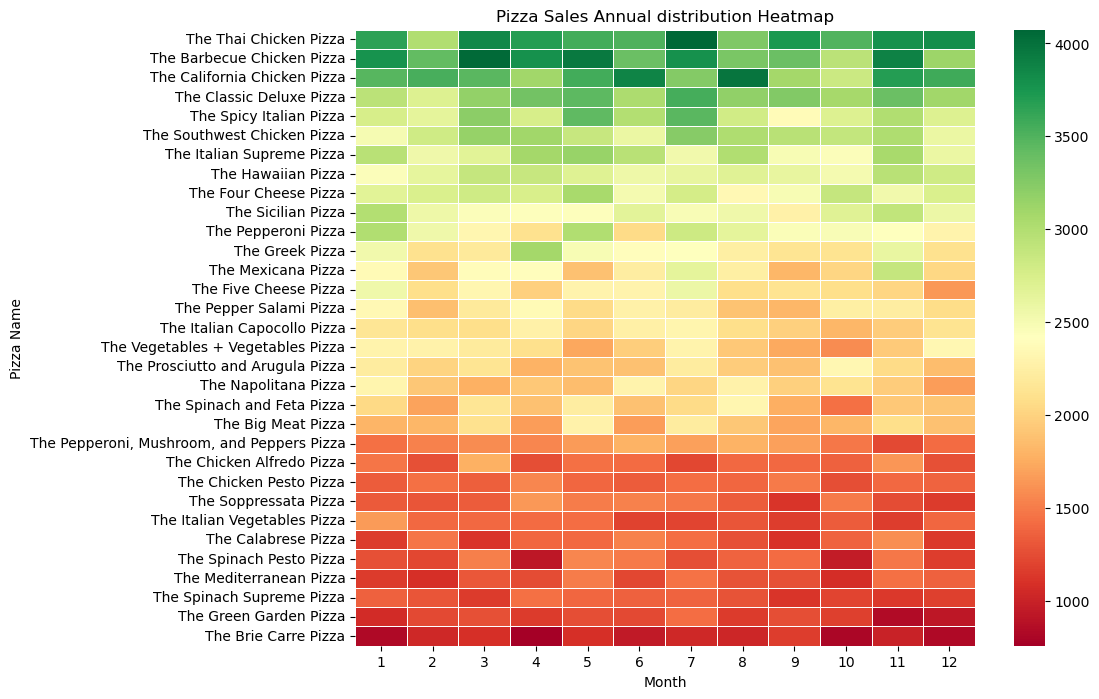

In [58]:
pivot_table2=pivot_table1.drop('total_revenue',axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table2, cmap='RdYlGn', annot=False, fmt=".2f", linewidths=0.5)

plt.title('Pizza Sales Annual distribution Heatmap')
plt.xlabel('Month')
plt.ylabel('Pizza Name')

plt.show()

Text(0.5, 0, 'Sold units')

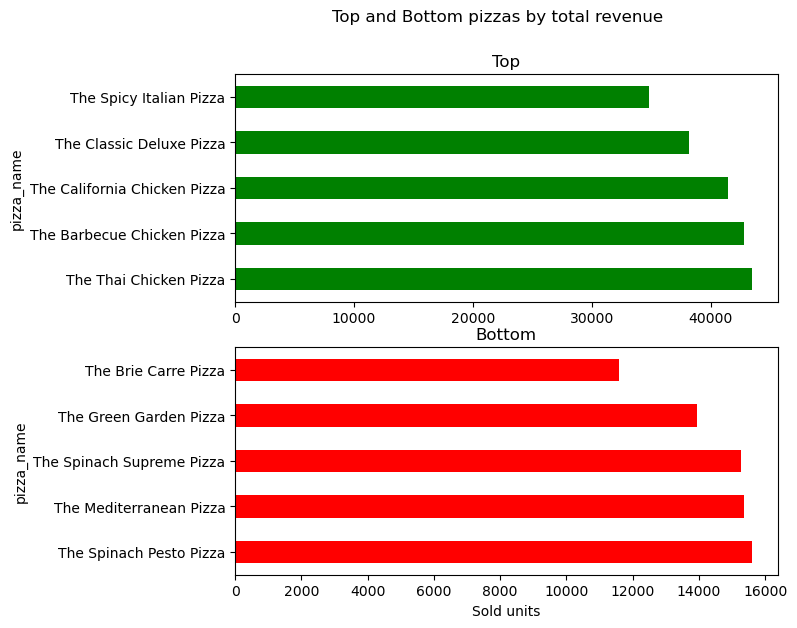

In [13]:
top_7 = pivot_table1['total_revenue'].head(5)
bottom_7 = pivot_table1['total_revenue'].tail(5)

# Creating subplots
fig, axes = plt.subplots(2,1,figsize=(7, 6.5))
plt.suptitle('Top and Bottom pizzas by total revenue')

# Plotting the first 7 pizzas on the first subplot
top_7.plot.barh(ax=axes[0],color='green')
axes[0].set_title('Top')


# Plotting the last 7 pizzas on the second subplot
bottom_7.plot.barh(ax=axes[1],color='red')
axes[1].set_title('Bottom')
axes[1].set_xlabel('Sold units')


In [60]:
cols1=df.columns
df['dayofweek']=df['daytime'].dt.dayofweek
df['hours']=df['daytime'].dt.hour
df['month']=df['daytime'].dt.month
df['dayofyear']=df['daytime'].dt.dayofyear


In [61]:
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

dfday=df.copy()
dfday = dfday.groupby(df['dayofweek']).sum()
dfday.index = dfday.index.map(day_names)

C:\Users\Utente\AppData\Local\Temp\ipykernel_9280\1384365448.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfday = dfday.groupby(df['dayofweek']).sum()


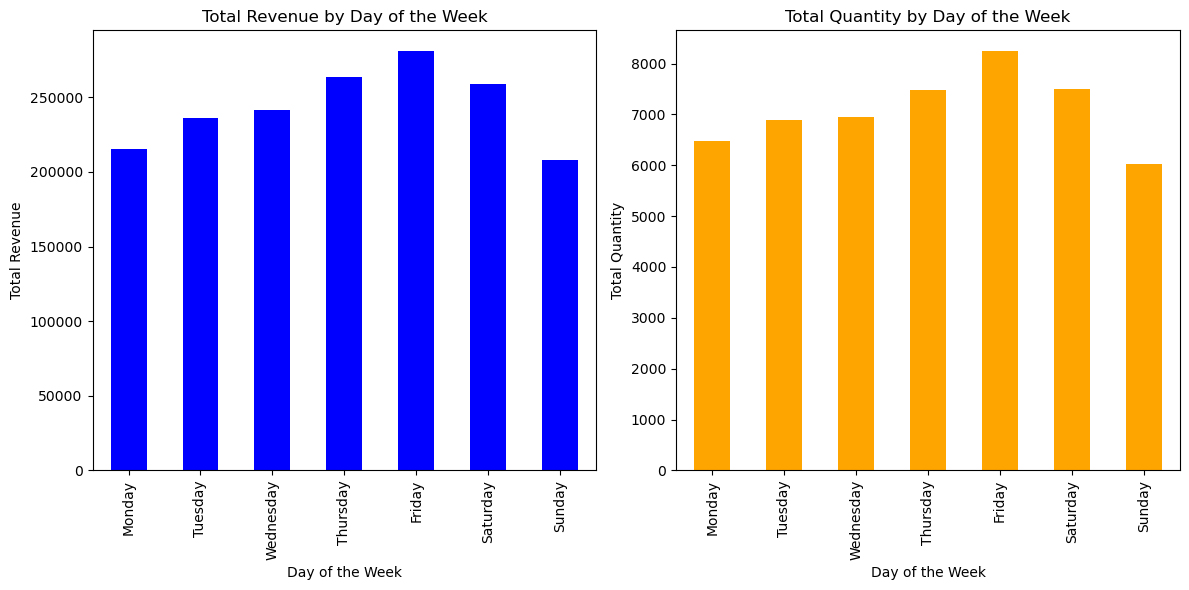

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Plotting total revenue
dfday.plot(y='total_revenue_k', kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Total Revenue by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Total Revenue')
axes[0].legend().set_visible(False)

# Plotting quantity
dfday.plot(y='quantity', kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Total Quantity by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Total Quantity')
axes[1].legend().set_visible(False)

plt.tight_layout()
plt.show()

The most productive day is Friday while the less productive is Sunday.

C:\Users\Utente\AppData\Local\Temp\ipykernel_9280\3441008458.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfhour = dfhour.groupby(df['hours']).sum()


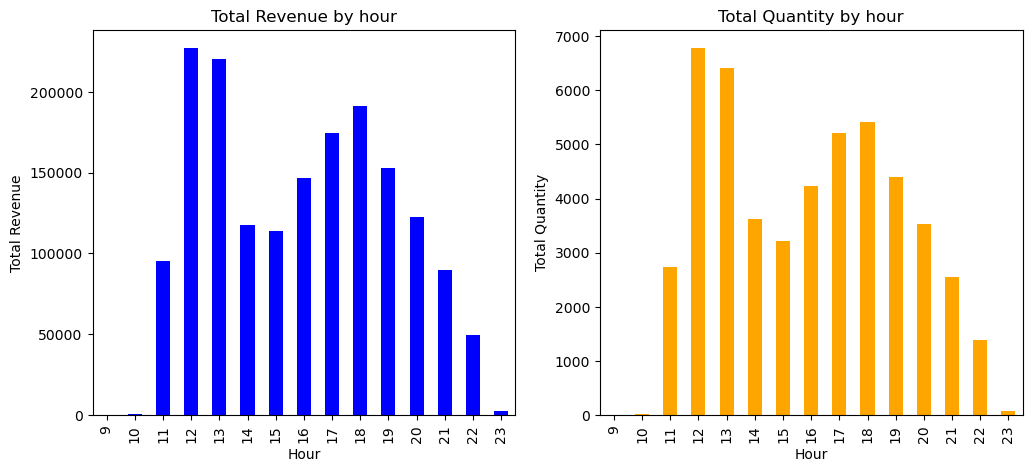

In [19]:
dfhour=df.copy()
dfhour = dfhour.groupby(df['hours']).sum()
dfhour=dfhour.sort_index()
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Plotting total revenue
dfhour.plot(y='total_revenue_k', kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Total Revenue by hour')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Total Revenue')
axes[0].legend().set_visible(False)

# Plotting quantity
dfhour.plot(y='quantity', kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Total Quantity by hour')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Total Quantity')
axes[1].legend().set_visible(False)

There's a peak of sales at lunch and it's mainly concentrated among 12 and 13. The dinner's peak instead is around 18:00.

Text(0, 0.5, 'Total Quantity')

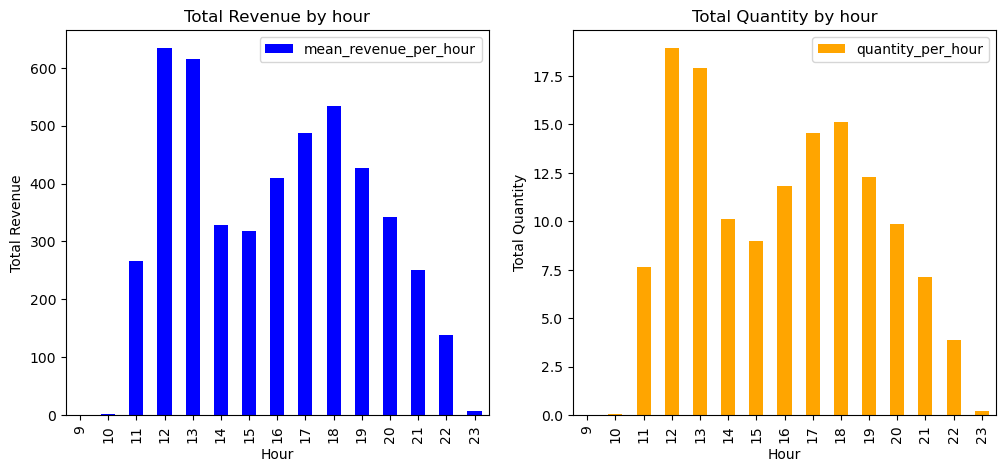

In [21]:
dfhour['mean_revenue_per_hour']=(dfhour['total_revenue_k']/358)
dfhour['quantity_per_hour']=(dfhour['quantity']/358)
dfhour=dfhour.sort_index()
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Plotting total revenue
dfhour.plot(y='mean_revenue_per_hour', kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Total Revenue by hour')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Total Revenue')

# Plotting quantity
dfhour.plot(y='quantity_per_hour', kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Total Quantity by hour')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Total Quantity')

By checking the average quantity of pizzas sold per hour we can say that our seats capacity is probably overestimated. By looking at the graph we see that in the busiest hour, the number of pizza sold reach 20 on average, way less than our capacity of 60 seats. This analysis makes sense by using the approximation that every customer spends one hour eating and not less.

In [22]:

dfmonth=df.copy()
month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

dfmonth = dfmonth.groupby('month').sum()
dfmonth=dfmonth.sort_index()
dfmonth.index = dfmonth.index.map(month_names)
dfmonth=dfmonth[['quantity','total_price']]
dfmonth

C:\Users\Utente\AppData\Local\Temp\ipykernel_9280\3954384684.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfmonth = dfmonth.groupby('month').sum()


,quantity,total_price
month,,
January,4232,69793.30
February,3961,65159.60
March,4261,70397.10
April,4151,68736.80
May,4328,71402.75
June,4107,68230.20
July,4392,72557.90
August,4168,68278.25
September,3890,64180.05


(3500.0, 4611.6)

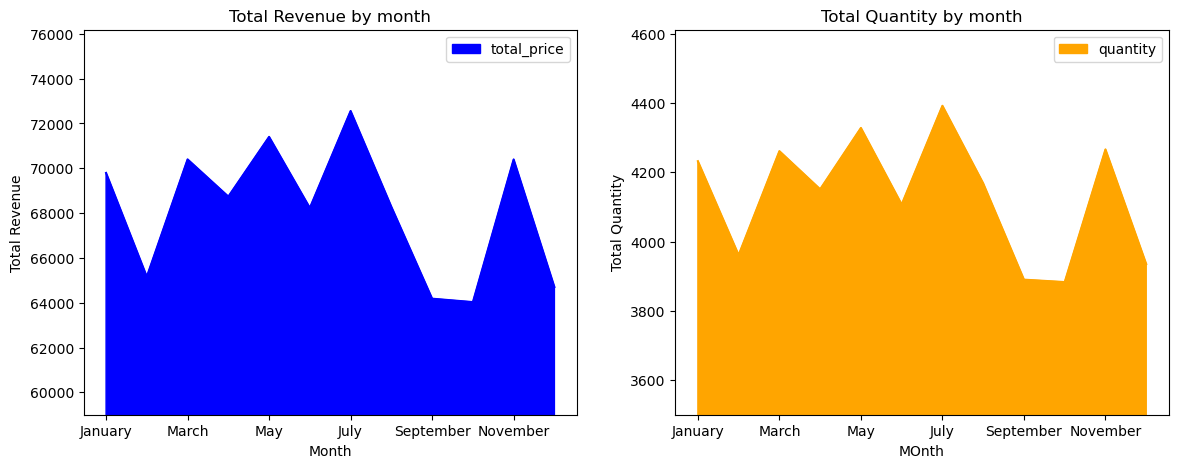

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Plotting total revenue
dfmonth.plot(y='total_price', kind='area', ax=axes[0], color='blue')
axes[0].set_title('Total Revenue by month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Revenue')
axes[0].set_ylim(59000, None)

# Plotting quantity
dfmonth.plot(y='quantity', kind='area', ax=axes[1], color='orange')
axes[1].set_title('Total Quantity by month')
axes[1].set_xlabel('MOnth')
axes[1].set_ylabel('Total Quantity')
axes[1].set_ylim(3500, None)

In [25]:
dfdayofyear

,order_details_id,order_id,quantity,unit_price,total_price,total_revenue_k,dayofweek,hours,month
2015-01-01,13041,5300,162,2697.85,2713.85,23.874,483,2523,161
2015-01-02,38640,16344,165,2643.15,2731.90,60.482,640,2645,160
2015-01-03,61369,25829,158,2596.15,2662.40,92.572,770,2547,154
2015-01-04,56021,24063,106,1755.45,1755.45,83.673,636,1726,106
2015-01-05,77682,34193,125,1994.95,2065.95,116.029,0,1930,121
...,...,...,...,...,...,...,...,...,...
2015-12-20,4189398,1840966,89,1389.05,1419.00,6033.243,522,1352,1044
2015-12-21,4921347,2162349,102,1637.20,1637.20,7087.047,0,1575,1224
2015-12-22,3722026,1634799,80,1312.50,1353.25,5359.550,77,1174,924
2015-12-23,3534149,1551878,82,1201.65,1337.80,5088.628,146,1048,876


C:\Users\Utente\AppData\Local\Temp\ipykernel_9280\2528645813.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfdayofyear = dfdayofyear.groupby('dayofyear').sum()


Text(0, 0.5, 'Total Quantity')

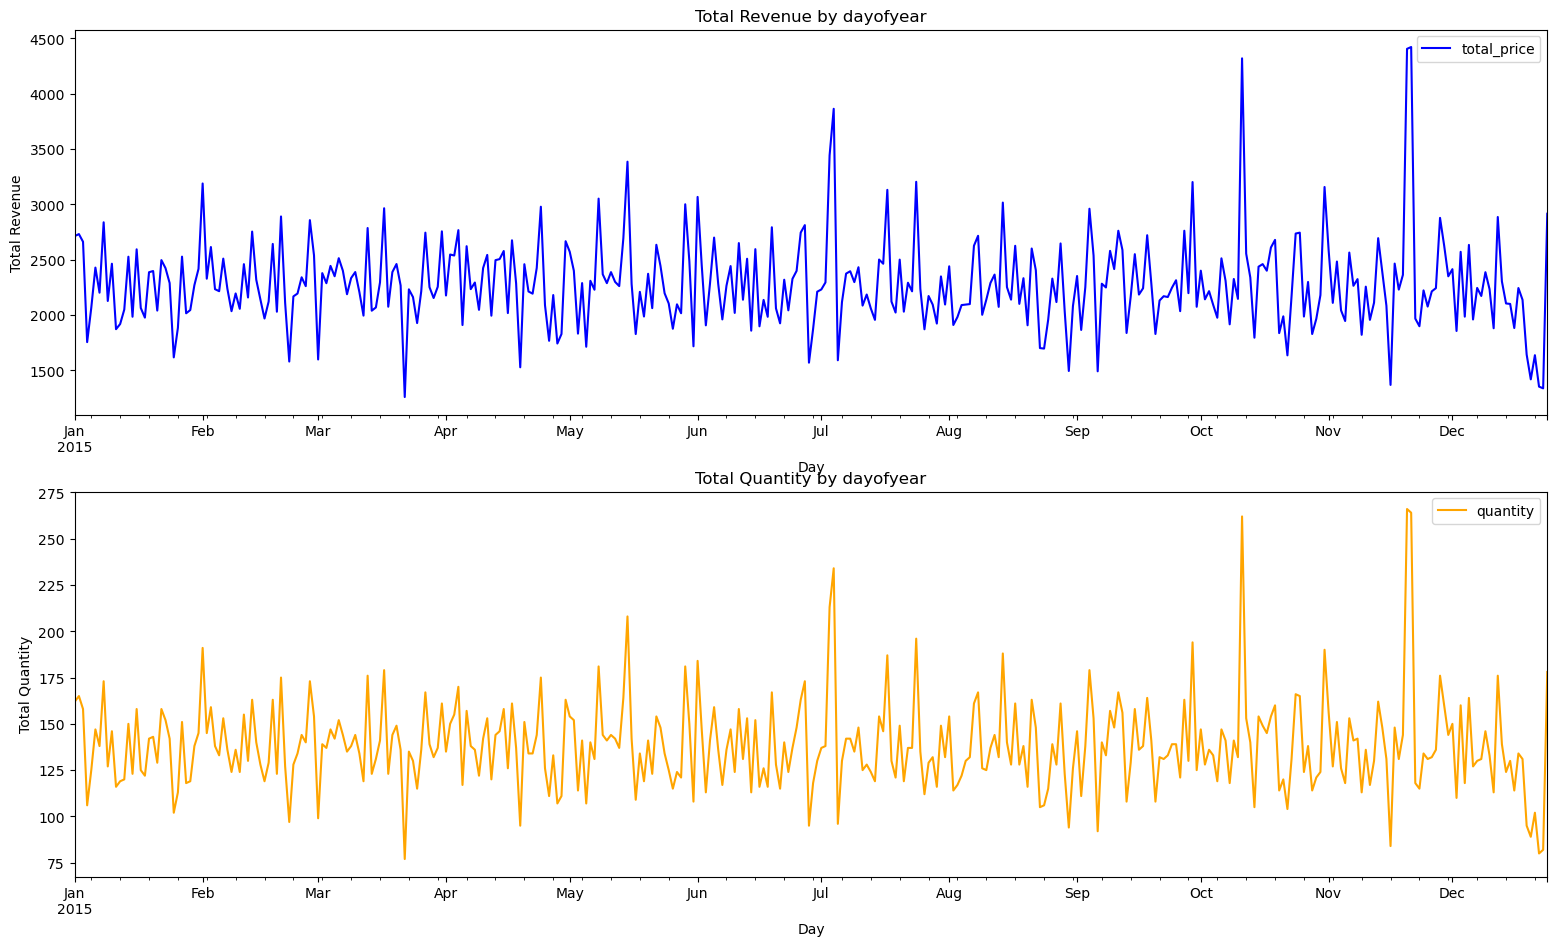

In [26]:
dfdayofyear=df.copy()
dfdayofyear = dfdayofyear.groupby('dayofyear').sum()
start_date = '2015-01-01'
end_date = '2015-12-24'
date_index = pd.date_range(start=start_date, end=end_date, freq='D')

dfdayofyear=dfdayofyear.set_index(date_index)


fig, axes = plt.subplots(2,1, figsize=(19,11))

# Plotting total revenue
dfdayofyear.plot(y='total_price', ax=axes[0], color='blue')
axes[0].set_title('Total Revenue by dayofyear')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Total Revenue')

# Plotting quantity
dfdayofyear.plot(y='quantity', ax=axes[1], color='orange')
axes[1].set_title('Total Quantity by dayofyear')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Total Quantity')

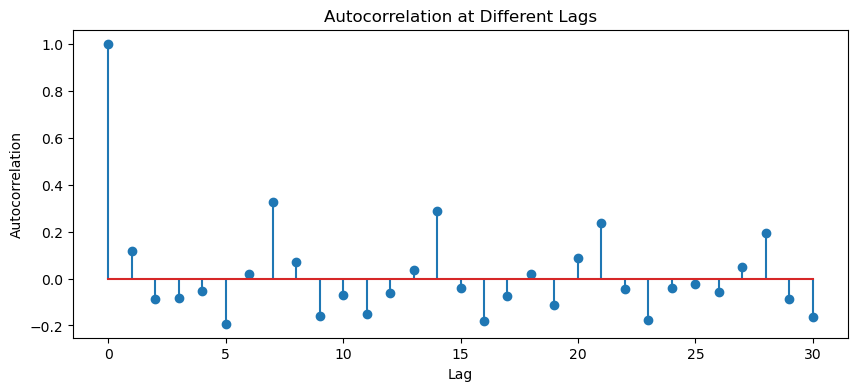

In [27]:
max_lag = 30  # Set the maximum lag you want to consider
autocorrelation = [dfdayofyear['total_price'].autocorr(lag) for lag in range(max_lag + 1)]

# Plot autocorrelation
plt.figure(figsize=(10, 4))
plt.stem(range(max_lag + 1), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation at Different Lags')
plt.show()

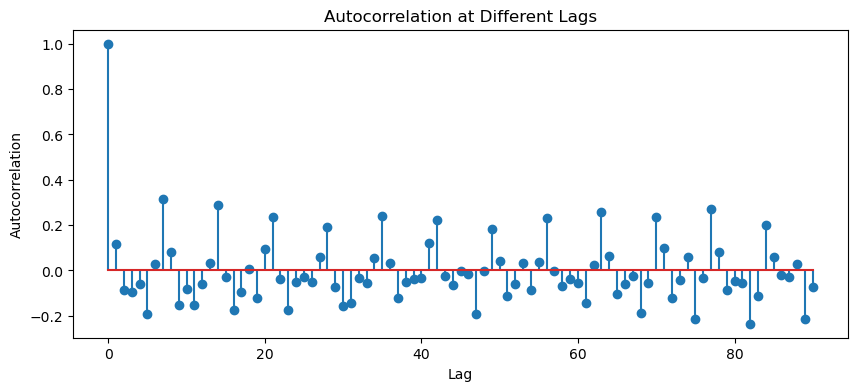

In [28]:
max_lag = 90  # Set the maximum lag you want to consider
autocorrelation = [dfdayofyear['quantity'].autocorr(lag) for lag in range(max_lag + 1)]

# Plot autocorrelation
plt.figure(figsize=(10, 4))
plt.stem(range(max_lag + 1), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation at Different Lags')
plt.show()

From the previous autocorrelation lag analysis, we can see that the peaks show a 7-day pattern, combining this information with the previous graphs we could assume that that peak coincides with Friday. This information will be useful for the next analysis.

# Time series decomposition

In the following code I'm going to decompose the revenue time series in its Trends, Seasonality and error (the residual part).

This kind of analysis could be useful to see how the revenue are performing in a normalized scenario (without trends).

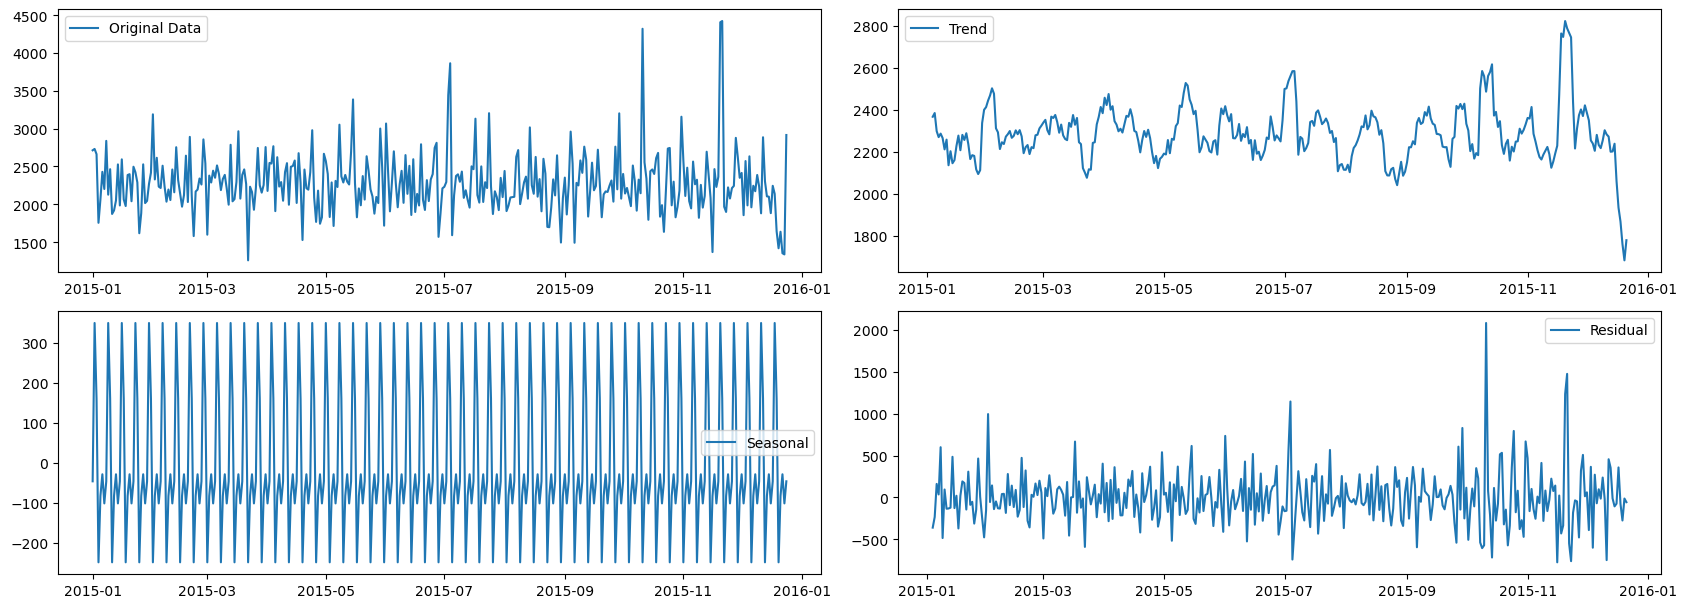

In [30]:
decomposition = seasonal_decompose(dfdayofyear['total_price'], period=7)

plt.figure(figsize=(17, 12))

# Original Data
plt.subplot(4, 2, 1)
plt.plot(dfdayofyear['total_price'], label='Original Data')
plt.legend()

# Trend
plt.subplot(4, 2, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

# Seasonal
plt.subplot(4, 2, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

# Residual
plt.subplot(4, 2, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

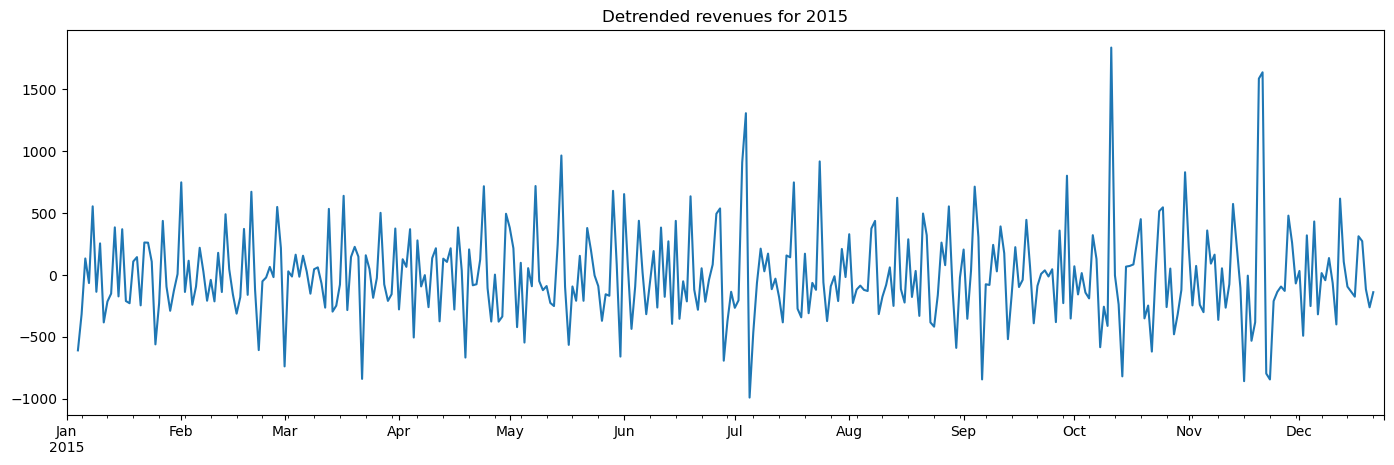

In [78]:
detrended=((dfdayofyear['total_price'])-decomposition.trend)
detrended.plot(figsize=(17,5))
plt.title('Detrended revenues for 2015')
plt.show()

# Revenue forecasting
In the following code I will try to predict the revenue for the month of January 2016. In order to do that I'm going to use a function calle autoarima that select automatically the best paramaters for an arima/sarima model, the only input i'm giving to the function is the weekly seasonality.

In [71]:
autoar = auto_arima(y = dfdayofyear['total_price'],x=(dfdayofyear[['month','hours','dayofweek']]),
                   m = 7,
                   seasonal=True)
autoar.summary()

c:\Users\Utente\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(2,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\Utente\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\Utente\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\Utente\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\Utente\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "c:\Users\Utente\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  358
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 7)   Log Likelihood               -2625.243
Date:                            Thu, 28 Sep 2023   AIC                           5266.486
Time:                                    12:52:11   BIC                           5297.530
Sample:                                01-01-2015   HQIC                          5278.832
                                     - 12-24-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2953.0103    805.499      3.666      0.000    1374.261    4531.760
ar.L1         -1.2264      0.296     -4.137      0.000      -1.807      -0.645
ar.L2         -0.2657      0.292     -0.910      0.363      -0.838       0.306
ma.L1          1.3766      0.292      4.711      0.000       0.804       1.949
ma.L2          0.4474      0.279      1.601      0.109      -0.100       0.995
ar.S.L7        0.3297      0.053      6.255      0.000       0.226       0.433
ar.S.L14       0.1499      0.062      2.403      0.016       0.028       0.272
sigma2      1.545e+05   9055.672     17.066      0.000    1.37e+05    1.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               548.68
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

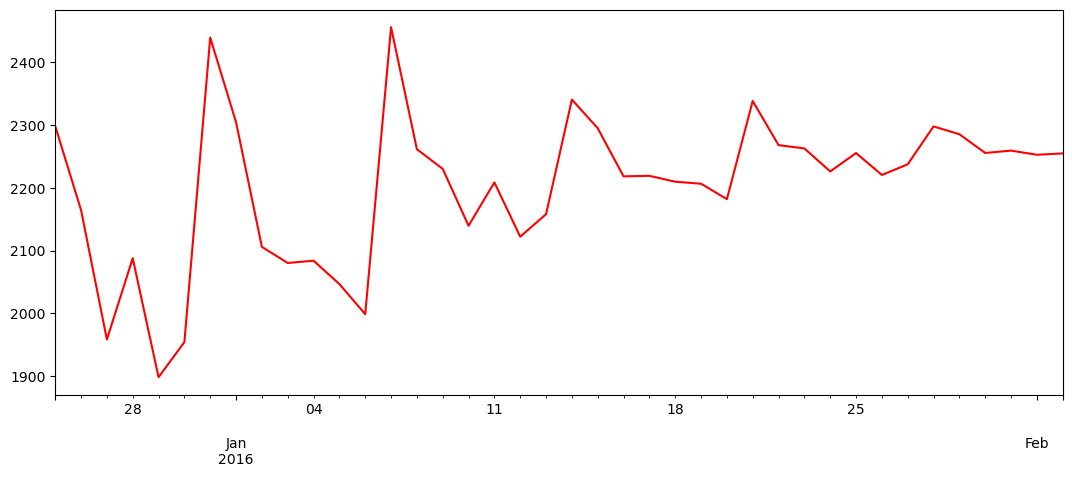

In [72]:
preds=autoar.predict(n_periods=40)
preds.plot(figsize=(13,5),kind='line',color='red')
plt.show()

Here's our prediction! To be honest this is a pretty simple model but it could be improved by inputing more meaningfully features like temperature or the holydays calendar.

In [49]:
preds=pd.DataFrame(preds)
preds

,0
2015-12-25,2298.344311
2015-12-26,2164.576066
2015-12-27,1958.481779
2015-12-28,2087.909085
2015-12-29,1898.451539
2015-12-30,1954.256645
2015-12-31,2439.358370
2016-01-01,2304.575522
2016-01-02,2106.007618
2016-01-03,2080.371053
